In [21]:

from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from scipy.stats import expon
import pandas as pd
import numpy as np


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from sklearn.model_selection import KFold

In [22]:
from sklearn.datasets import make_regression

import numpy as np
n_samples = 1000
hazard_ratio = 2.0
random_state = 42
X, y = make_regression(n_samples=n_samples, n_features=10, noise=1, random_state=n_samples)
time_event =  abs(y)
event = np.full(n_samples, True)
max_time = max(y)
from sksurv.util import Surv
yt = Surv.from_arrays(event=event, time=time_event)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, yt, test_size=0.2, random_state=random_state)

# Create censored data


In [24]:

def censor_data(data):
# Generate a random censoring amount between 0.1 and 0.3
    random_censoring = np.random.uniform(0.1, 0.3)

# Determine the number of observations to censor
    n_to_censor = int(len(data) * random_censoring)

# Ensure we do not exceed the length of the DataFrame
    n_to_censor = min(n_to_censor, len(data))

# Randomly select indices to censor
    counter_list = np.random.choice(len(data), n_to_censor, replace=False)

    data_cen = pd.DataFrame(columns=['event','time'])
    counter = 0
    for event, time in data:
    
        if counter in counter_list:
            event = False
            time_cen = np.random.uniform(low=0, high=time, size=1)
            time = time_cen
       

    
        
        data_cen.loc[counter] =  [event,time]
        counter += 1
    return data_cen


In [25]:
y_cen = censor_data(yt)
yt_cen = Surv.from_arrays(event=y_cen['event'], time=y_cen['time'])

## create dataframe
#CCA

In [26]:
cca_df= pd.DataFrame(X).join(pd.DataFrame(yt_cen))
cca_data = cca_df[cca_df['event']==True]
cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
cca_X = cca_data[cca_data.columns[:-2]]

## Plot the difference in time of the dataset

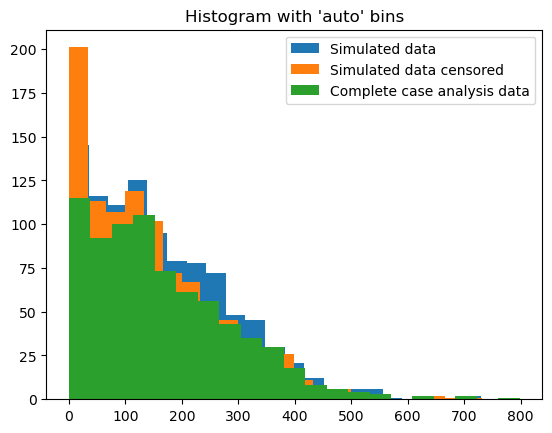

In [27]:
plt.hist(yt['time'], bins='auto', label= 'Simulated data')  # arguments are passed to np.histogram
plt.hist(yt_cen['time'], bins='auto', label= 'Simulated data censored')  # arguments are passed to np.histogram
plt.hist(cca_yt['time'], bins='auto', label= 'Complete case analysis data')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.legend()
plt.show()

#Complete Case analyses
Checking if event equals True, else delete;

In [28]:
cca_df= pd.DataFrame(X).join(pd.DataFrame(yt_cen))
cca_data = cca_df[cca_df['event']==True]
cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
cca_X = cca_data[cca_data.columns[:-2]]

# Metric functions

In [72]:
## Create function to test all metrics in one swoop

def test_metrics(models, X_train = X_train, y_train = y_train, X_test = X_test, y_test=y_test, df= cca_df):
    from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score, brier_score
)
    print(len(models))

    metrics_dic = {}
    # Max time calculation for evaluation
    max_time_test = round(max(df['time']),0) - 1
    for model in models:
        scores = {}
    #c-index
        c_index = model.score(X_test, y_test)
        scores['C-index'] = round(c_index,3)


   
    # Brier score
        survs = model.predict_survival_function(X_test)

    
        preds = [fn(max_time_test) for fn in survs]
        score_brier = brier_score(y_train, y_test, preds, max_time_test)
        scores['Brier score'] = round(float(score_brier[1]),4)


        metrics_dic[f'{str(model)}'] = scores


    return metrics_dic

def time_dependent_roc(models,model_name, X_train = X_train, y_train = y_train, X_test = X_test, y_test=y_test, df=cca_df):
    max_time_test = round(max(df['time']),0)-1
    times = time_points = np.linspace(df['time'].min(), df['time'].max(), num=20) 
    model_auc_dic = {}
    for model in models:
        temp_dic = {}
        temp_dic[f'{model}_funcs'] = model.predict_cumulative_hazard_function(X_test, return_array=False)
        temp_dic[f'{str(model)}_scores'] = np.vstack([chf(times) for chf in temp_dic[f'{model}_funcs']])


        temp_dic[f'{str(model)}_auc'], temp_dic[f'{str(model)}_mean_auc'] = cumulative_dynamic_auc(y_train, y_test, temp_dic[f'{str(model)}_scores'], times)
        #print(temp_dic)
        plt.plot(times, temp_dic[f'{str(model)}_auc'] , "o-", label=f"{model_name} (mean AUC = {temp_dic[f'{str(model)}_mean_auc']})")
    plt.xlabel("days after enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

# Basline model

In [73]:
# basic RSF model
def basic_rsf(df):
    rsf = RandomSurvivalForest(random_state = random_state)

    yt = Surv.from_arrays(event=df['event'], time=df['time'])
    X = df.drop(columns=['event', 'time'])

    X_train, X_test, y_train, y_test = train_test_split(X, yt, test_size=0.2, random_state=random_state)
    rsf_basic = rsf.fit(X_train,y_train)


    results = test_metrics([rsf_basic], X_train,  y_train, X_test, y_test)
    plot = time_dependent_roc([rsf_basic],'base RSF',df, X_train,  y_train, X_test, y_test)
    return results, plot



In [74]:
basic_rsf(cca_df)

1


ValueError: all times must be within follow-up time of test data: [0.7826340473063089; 513.3607939537344[

## Creating models using the different methods

In [32]:
## Censored model

X_train_cen, X_tes_cen, y_train_cen, y_test_cen = train_test_split(X, yt_cen, test_size=0.2, random_state=random_state)

In [33]:
# basic RSF model
rsf = RandomSurvivalForest(random_state = random_state)
rsf_cen = rsf.fit(X_train_cen, y_train_cen)
rsf_cen.score(X_tes_cen, y_test_cen)


0.7164167324388319

In [49]:
## CCA
def complete_case_analysis(df):
    rsf = RandomSurvivalForest(random_state = random_state)
    
    cca_df= pd.DataFrame(X).join(pd.DataFrame(yt_cen))
    cca_data = cca_df[cca_df['event']==True]
    cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
    cca_X = cca_data.drop(columns=['event', 'time'])

    X_train, X_test, y_train, y_test = train_test_split(cca_X, cca_yt, test_size=0.2, random_state=random_state)

    rsf_cca = rsf.fit(X_train, y_train)
    

    results = test_metrics([rsf_cca], X_train,  y_train, X_test, y_test)
    plot = time_dependent_roc([rsf_cca],'CCA', X_train,  y_train, X_test, y_test)
    return results, plot

In [57]:
complete_case_analysis(cca_df)

1


ValueError: time must be smaller than largest observed time point: 715.0986902290384

## Imputation

In [36]:
import numpy as np
import pandas as pd
from lifelines import WeibullFitter
from scipy.stats import weibull_min

def imputation_model(df):

    def impute_surv_data(df):
        censored_data = df[df['event'] == 0].copy()
        uncensored_data = df[df['event'] == 1].copy()

    # 1. Fit a Weibull model to uncensored data
        weibull_fitter = WeibullFitter()
        weibull_fitter.fit(uncensored_data['time'], event_observed=uncensored_data['event'])

    # Get Weibull parameters for sampling
        weibull_shape = weibull_fitter.rho_
        weibull_scale = weibull_fitter.lambda_

    # 2. Impute times for censored data using the Weibull distribution
        imputed_times = []
        for index, row in censored_data.iterrows():
            observed_time = row['time']
            
            # Generate a potential event time from the Weibull distribution
            potential_event_time = weibull_min.rvs(c=weibull_shape, scale=weibull_scale)
            
            # Ensure the imputed event time is after the observed (censored) time
            if potential_event_time > observed_time:
                imputed_times.append(potential_event_time)
            else:
                imputed_times.append(observed_time + weibull_min.rvs(c=weibull_shape, scale=weibull_scale))  # Add additional time if needed

        # Add imputed times to the censored data
        censored_data['imputed_time'] = imputed_times

        # For uncensored data, the imputed time is the observed time
        uncensored_data['imputed_time'] = uncensored_data['time']

        # Combine censored and uncensored data back together and set all events to 1
        df_imputed = pd.concat([uncensored_data, censored_data], axis=0).sort_index()
        df_imputed['event'] = 1  # Set all events to 1

        return df_imputed[df_imputed.columns[:-3]], df_imputed[['event','imputed_time']]
    
    X, y = impute_surv_data(df)
    yt = Surv.from_arrays(event=y['event'].astype('bool'), time=y['imputed_time'])
    X_train, X_test, y_train, y_test = train_test_split(X, yt, test_size=0.2, random_state=random_state)
    rsf_imp = rsf.fit(X_train, y_train)
    

    results = test_metrics([rsf_imp], X_train,  y_train, X_test, y_test)
    plot = time_dependent_roc([rsf_imp],'Imputation', X_train,  y_train, X_test, y_test)

    return results, plot


1


({'RandomSurvivalForest(random_state=42)': {'C-index': 0.684,
   'Brier score': 0.0049}},
 None)

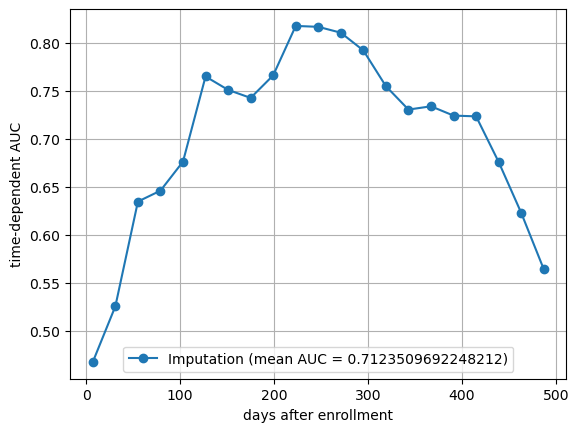

In [37]:
imputation_model( cca_df)

# STUART

In [45]:
import numpy as np
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest
from scipy.stats import norm

def stuart(df):
    #STUART method

    # Function to train a base model
    def train_base_model(observed):
        # Prepare features (X) and survival data (y) for Random Survival Forest
        X_train = observed.drop(columns=['time', 'event'])
        y_train = observed[['event', 'time']].to_records(index=False)
        
        # Initialize and train the Random Survival Forest
        model = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=3, random_state=0)
        model.fit(X_train, y_train)
        
        return model


    def predict_survival_time(model, censored):
        X_censored = censored.drop(columns=['time', 'event'])
        
        # Predict survival functions for each instance
        survival_functions = model.predict_survival_function(X_censored)
        
        predictions = []
        variances = []
        
        # Iterate over survival functions and compute the median survival time (Tp)
        for surv_func in survival_functions:
            # surv_func is a StepFunction object
            # surv_func.x contains the time points and surv_func.y contains the survival probabilities
            
            # Find the time point where survival probability is closest to 50%
            median_time = surv_func.x[np.argmin(np.abs(surv_func.y - 0.5))]  # Median survival time
            
            predictions.append(median_time)
            
            # Variance estimation (currently a placeholder, can be refined)
            variances.append(2.0)  # Placeholder variance for simplicity
        
        return np.array(predictions), np.array(variances)


    # Function to calculate tolerance interval
    def calculate_tolerance_interval(predictions, variances, confidence_level=0.95):
        # Calculate 95% tolerance interval using normal distribution
        z_score = norm.ppf(1 - (1 - confidence_level) / 2)
        lower_bound = predictions - z_score * np.sqrt(variances)
        upper_bound = predictions + z_score * np.sqrt(variances)
        return lower_bound, upper_bound

    # Function to update the training set with confident predictions
    def update_training_set(censored, observed, predictions, variances, lower_bound, upper_bound):
        confident_predictions = []
        new_observed = observed.copy()

        for idx, (prediction, variance, lb, ub) in enumerate(zip(predictions, variances, lower_bound, upper_bound)):
            Tc = censored.iloc[idx]['time']  # Censoring time of the instance
            
            # Check if Tc > Tp + 2σ to consider it confident
            if Tc > prediction + 2 * np.sqrt(variance):
                # Add confident prediction to training data (observed) and remove from censored
                new_observed = pd.concat([new_observed, censored.iloc[[idx]]], ignore_index=True)
                confident_predictions.append(True)
            else:
                confident_predictions.append(False)
        
        # Update censored to remove confident predictions
        new_censored = censored[~np.array(confident_predictions)]
        
        return new_observed, new_censored

    # Main function to run the iterative process with Random Survival Forest
    def survival_prediction_model(observed, censored, max_iterations=50):
        iteration = 0
        while iteration < max_iterations:
            iteration += 1
            
            # Train the base Random Survival Forest model on observed data
            model = train_base_model(observed)
            
            # Make predictions for censored instances
            predictions, variances = predict_survival_time(model, censored)
            
            # Sort predictions based on minimum variance (if required)
            sorted_indices = np.argsort(variances)
            predictions = predictions[sorted_indices]
            variances = variances[sorted_indices]
            censored_sorted = censored.iloc[sorted_indices]
            
            # Calculate the tolerance interval for predictions
            lower_bound, upper_bound = calculate_tolerance_interval(predictions, variances)
            
            # Identify confident predictions to add to the training set
            observed, censored = update_training_set(censored_sorted, observed, predictions, variances, lower_bound, upper_bound)
            
            # Stop if no new confident predictions are added
            if observed.shape[0] == len(observed):  # Check if training set size increased
                print(f"Iteration {iteration}: No confident predictions added.")
                break

        return model, observed
    observed  = df[df['event']==True]
    censored = df[df['event']==False]
    observed['event'] = observed['event'].astype(bool)
    censored['event'] = censored['event'].astype(bool)
    final_model, final_observed = survival_prediction_model(observed, censored)

    def prepare_data(data):
        event_time = Surv.from_arrays(event=data['event'], time=data['time'])
        features = data[data.columns[:-2]]

        return  features, event_time
    stuart_X , stuart_y = prepare_data(final_observed[['event', 'time']])

    X_train, X_test, y_train, y_test = train_test_split(stuart_X, stuart_y, test_size=0.2, random_state=random_state)

    rsf_stuart = rsf.fit(X_train, y_train)
        

    results = test_metrics([rsf_stuart], X_train,  y_train, X_test, y_test)
    plot = time_dependent_roc([rsf_stuart], model_name= 'STUART')
    return results, plot

In [46]:
stuart(cca_df)
    


/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_73559/3059125330.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed['event'] = observed['event'].astype(bool)
/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_73559/3059125330.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censored['event'] = censored['event'].astype(bool)


Iteration 1: No confident predictions added.


ValueError: at least one array or dtype is required

In [42]:
## ICPW

def icpw_model(df):

    rsf = RandomSurvivalForest(random_state = random_state)
    from sklearn.linear_model import LogisticRegression


    def prepare_data(data):
            event_time = Surv.from_arrays(event=data['event'], time=data['time'])
            features = data[data.columns[:-2]]

            return  features, event_time
    
    X , yt = prepare_data(df)
# Fit a logistic regression model to predict censoring
    X_censor =  X

    y_censor = 1  - yt_cen['event'].astype('int')  # 1 for censored, 0 for event

#cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
    model = LogisticRegression()
    model.fit(X_censor, y_censor)

    yt = pd.DataFrame(columns=['event', 'time'], data= yt)
# Predict the probability of being censored
    censor_prob = model.predict_proba(X_censor)[:, 1]
    yt['weights'] = 1 / censor_prob
    X_train, X_test, y_train, y_test = train_test_split(X_censor, yt, test_size=0.2, random_state=random_state)
    yt_temp_train = Surv.from_arrays(event=y_train['event'], time=y_train['time'])
    yt_temp_test = Surv.from_arrays(event=y_test['event'], time=y_test['time'])
    rsf_ICPW = rsf.fit(X_train,yt_temp_train , np.asanyarray(y_train['weights'].values))

    results = test_metrics([rsf_ICPW], X_train,  yt_temp_train, X_test, yt_temp_test)
    plot = time_dependent_roc([rsf_ICPW],'ICPW', X_train,  yt_temp_train, X_test, yt_temp_test)

    return results, plot


1


{'RandomSurvivalForest(random_state=42)': {'C-index': 0.716,
  'Brier score': 0.0101}}

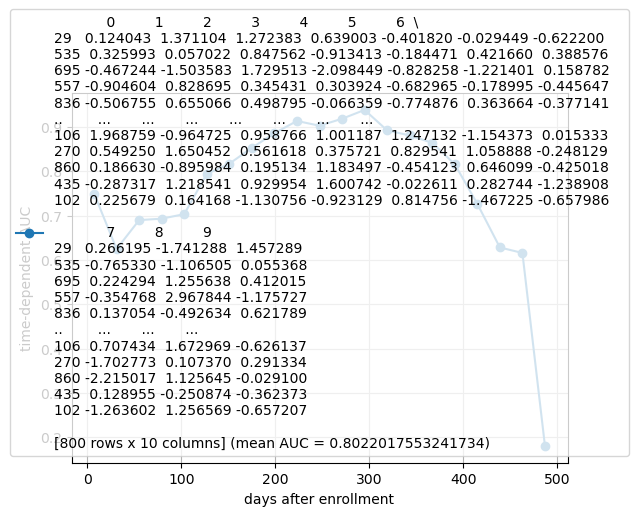

In [41]:
result, plot = icpw_model(cca_df)
result


# Plot all roc in one plot

In [25]:
models = [basic_rsf, complete_case_analysis, icpw_model, imputation_model, stuart ]

In [ ]:

for model in models:
    print(model(cca_df))

# table with all metrics 